**Introduction**
Ce Notebook sera une exploration complète des différentes étapes du traitement du big data nécessaires pour développer notre méthode de détection du cancer du sein. Nous nous concentrerons sur l'utilisation d'algorithmes de deep learning, en nous appuyant notamment sur les principes du réseau de neurones à convolution (CNN) .

En nous basant sur les travaux de recherche antérieurs et les principes du CNN, nous développerons une méthode spécifique pour la détection du cancer du sein. Notre approche s'appuiera sur l'analyse approfondie des données volumineuses disponibles, y compris les images médicales, les données cliniques et d'autres sources pertinentes

#Installer et importer les bibliothèques nécessaire

In [147]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-io

^C
ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user


In [148]:
# TensorFlow libraries
import tensorflow as tf  # Importation de la bibliothèque TensorFlow
from tensorflow.keras.applications.resnet_v2 import ResNet50V2  # Importation de la classe ResNet50V2 du module applications de keras
from tensorflow.keras.optimizers import RMSprop  # Importation de la classe RMSprop du module optimizers de keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importation de la classe ImageDataGenerator du module preprocessing.image de keras

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Importation des classes Dense, GlobalAveragePooling2D et Dropout du module layers de keras
from tensorflow.keras.models import Sequential  # Importation de la classe Sequential du module models de keras
from tensorflow.keras.optimizers import Adam  # Importation de la classe Adam du module optimizers de keras

# basic libraries
from sklearn.model_selection import train_test_split  # Importation de la fonction train_test_split du module model_selection de sklearn
from sklearn.metrics import classification_report, confusion_matrix  # Importation des classes classification_report et confusion_matrix du module metrics de sklearn

import numpy as np  # Importation de la bibliothèque numpy
import pandas as pd  # Importation de la bibliothèque pandas
import matplotlib.pyplot as plt  # Importation du module pyplot de la bibliothèque matplotlib
import seaborn as sns  # Importation de la bibliothèque seaborn
import cv2  # Importation de la bibliothèque cv2
import os  # Importation du module os

import glob  # Importation du module glob
from glob import glob  # Importation de la fonction glob depuis le module glob

print('cfait' )

cfait


**Lire les données d'image et de ficher CSV**

In [149]:
# Chemin d'accès aux fichiers PNG de l'ensemble de données RSNA Breast Cancer
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'

In [150]:
# Charger les données d'entraînement à partir du fichier CSV
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Afficher les premières lignes du DataFrame df_train
df_train.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [151]:
# Obtenir la taille du DataFrame df_train
len(df_train)


54706

In [152]:
# Obtenir la taille du sous-ensemble des données df_train contenant la valeur 1 dans la colonne 'implant'
len(df_train[df_train['implant'] == 1])


1477

In [153]:
# Le nombre de patients sans cancer malin
len(df_train[df_train['cancer'] == 0])


53548

In [154]:
# Le nombre de patients ayant subi une biopsie
len(df_train[df_train['biopsy'] == 1])


2969

In [155]:
# Le nombre de patients ayant un cancer malin
len(df_train[df_train['cancer'] == 1])

1158

In [156]:
# Le nombre de patients dont le cancer malin est invasif
len(df_train[df_train['invasive'] == 1])


818

In [157]:
# Le nombre de patients dont le cancer malin est invasif (même résultat que précédemment)
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])


818

<Axes: xlabel='class', ylabel='count'>

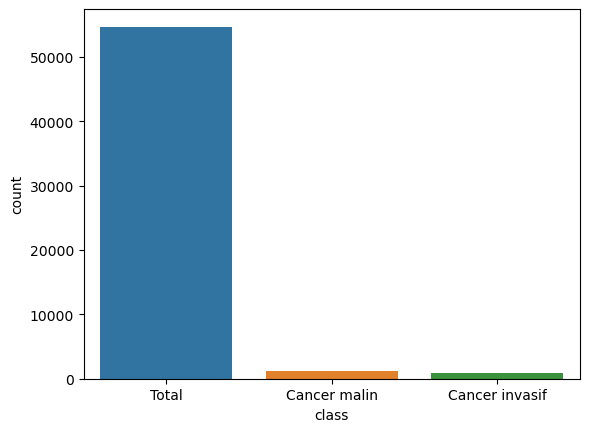

In [158]:
# La plupart des cas sont normaux ou non cancéreux. Ainsi, les médecins peuvent parfois ne pas remarquer le cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train), ['Cancer malin'] * len(df_train[df_train['cancer'] == 1]), ['Cancer invasif'] * len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns=["class"])

sns.countplot(x='class', data=data)


<Axes: xlabel='class', ylabel='count'>

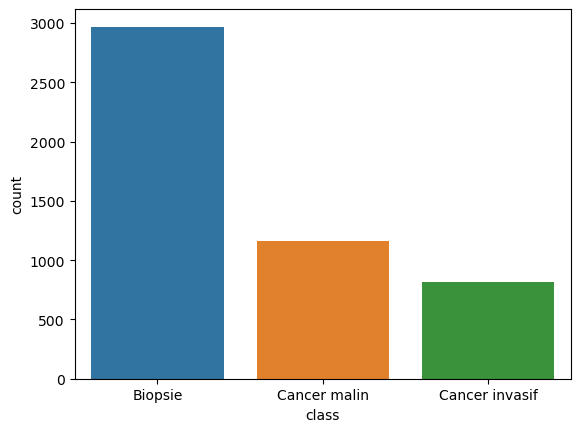

In [159]:
# Environ 3000 patients ont subi une biopsie et un cancer malin a été découvert chez certains d'entre eux.
data = pd.DataFrame(np.concatenate([['Biopsie'] * len(df_train[df_train['biopsy'] == 1]), ['Cancer malin'] * len(df_train[df_train['cancer'] == 1]), ['Cancer invasif'] * len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns=["class"])

sns.countplot(x='class', data=data)


In [160]:
# Le nombre de cas de cancer non malin à partir des biopsies
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])


1811

In [161]:
# Le nombre de cas de cancer malin à partir des biopsies
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])


1158

<Axes: xlabel='class', ylabel='count'>

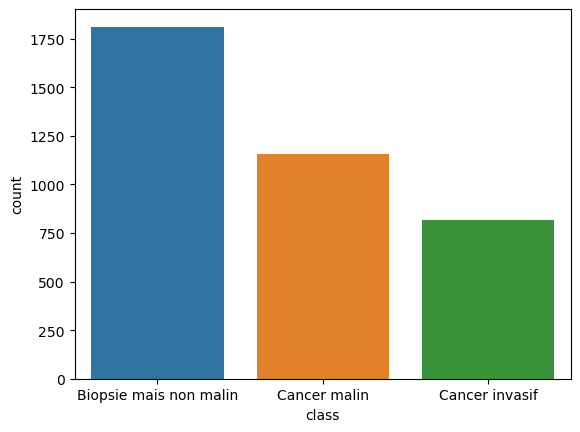

In [162]:
# 60% des biopsies ont donné un résultat de cancer non malin.
data = pd.DataFrame(np.concatenate([['Biopsie mais non malin'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]), ['Cancer malin'] * len(df_train[df_train['cancer'] == 1]), ['Cancer invasif'] * len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns=["class"])

sns.countplot(x='class', data=data)


In [163]:
# Les cas de cancer non malin ont été limités aux cas de biopsie.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop=True)
DF_train.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [164]:
# Le nombre de cas positifs (malins) et négatifs (non malins) doit être le même
# pour créer un jeu de données équilibré.

# Le DataFrame DF_train est regroupé par la colonne 'cancer' en utilisant la méthode groupby().
# Ensuite, la méthode apply() est utilisée avec une fonction lambda pour échantillonner aléatoirement 1158 cas de chaque groupe.
# L'argument replace=True permet de tirer des échantillons avec remplacement, garantissant ainsi un nombre égal de cas positifs et négatifs dans le jeu de données équilibré.
# La méthode reset_index(drop=True) est utilisée pour réinitialiser les index du DataFrame résultant.

DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace=True)).reset_index(drop=True)

# Enfin, la taille du nouveau jeu de données équilibré est affichée en utilisant la méthode shape[0] pour obtenir le nombre de lignes du DataFrame.

print('Nouvelle taille des données:', DF_train.shape[0])


Nouvelle taille des données: 2316


<Axes: xlabel='class', ylabel='count'>

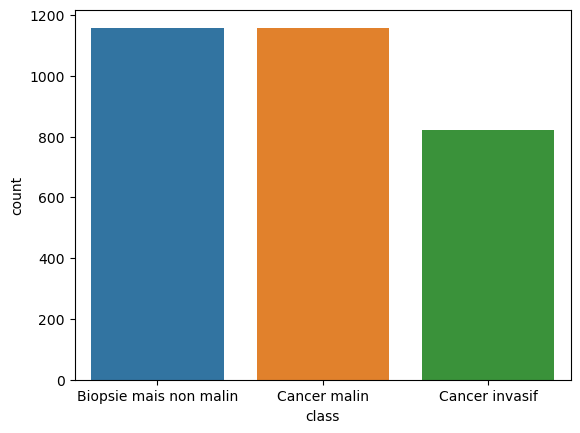

In [165]:
# Généralement, le cancer invasif est confirmé par biopsie, pas par mammographie.
# Il est peut-être également extrêmement difficile pour l'IA de détecter le cancer invasif à partir de mammographies.

data = pd.DataFrame(np.concatenate([['Biopsie mais non malin'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]), ['Cancer malin'] * len(DF_train[DF_train['cancer'] == 1]), ['Cancer invasif'] * len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns=["class"])

sns.countplot(x='class', data=data)


# **Créer le chemin d'accès à chaque image**

In [166]:
# Create the path to each image.

# Parcourez chaque ligne du DataFrame DF_train.
# Pour chaque ligne, créez le chemin d'accès à l'image en utilisant os.path.join() pour combiner le chemin RSNA_512_path avec les valeurs de 'patient_id' et 'image_id' de la ligne actuelle.
# Ajoutez le chemin d'accès obtenu à la colonne 'path' du DataFrame DF_train.

for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')

# Affichez les premières lignes du DataFrame DF_train mis à jour, qui contient maintenant le chemin d'accès à chaque image dans la colonne 'path'.

DF_train.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,55629,1789023220,L,MLO,71.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5562...
1,1,4098,2047343579,L,MLO,40.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4098...
2,2,12203,1582443953,L,CC,60.0,0,1,0,NaN,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/1220...
3,1,2770,564729418,R,MLO,48.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2770...
4,1,58718,1546015970,L,MLO,66.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5871...


In [167]:
# a sample path
DF_train.loc[12,'path'] 
# Cette ligne de code affiche le chemin d'accès à une image spécifique dans le DataFrame DF_train.
#sélectionne la valeur de la colonne 'path' pour la treizième ligne (index 12) du DataFrame DF_train.
# Cela permet d'obtenir un exemple de chemin d'accès à une image spécifique.


'/kaggle/input/rsna-breast-cancer-512-pngs/2028_2077153957.png'

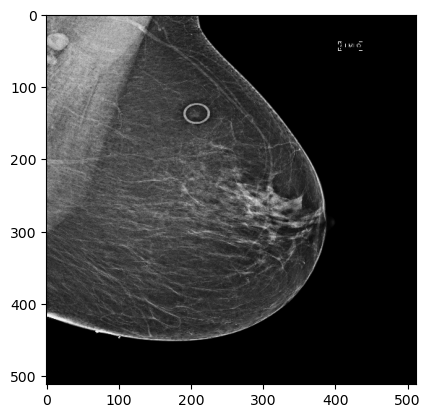

In [168]:
# a sample image

# Cette ligne de code lit une image à partir du chemin d'accès spécifique dans le DataFrame DF_train en utilisant la fonction cv2.imread().
# L'image est ensuite stockée dans la variable 'img'.

img = cv2.imread(DF_train.loc[0, 'path'])

# Cette ligne de code utilise la bibliothèque matplotlib et la fonction plt.imshow() pour afficher l'image.
# L'argument 'img' spécifie l'image à afficher.
# L'argument 'cmap = 'gray'' indique que l'image doit être affichée en utilisant une palette de couleurs en niveaux de gris.

plt.imshow(img, cmap='gray')


In [169]:
#La ligne de code img fait référence à la variable qui contient l'image chargée à partir du chemin d'accès spécifique dans le DataFrame DF_train.
img


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[147, 147, 147],
        [156, 156, 156],
        [161, 161, 161],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [170]:
img.shape #renvoie les dimensions de l'image chargée

(512, 512, 3)

In [171]:
# Divide the Data into Training and Validation

# Cette fois, nous divisons les données en ensembles d'entraînement et de validation, car les données de test existent déjà.

# La ligne de code suivante utilise la fonction train_test_split() pour diviser les données en ensembles d'entraînement et de validation.
# Les paramètres utilisés sont les suivants :
# - DF_train : le DataFrame contenant les données à diviser.
# - test_size = 0.30 : la proportion de données à utiliser pour la validation (30% dans cet exemple).
# - random_state = 2018 : la graine aléatoire utilisée pour la reproductibilité des résultats.
# - stratify = DF_train[['cancer']] : permet de s'assurer que les classes 'cancer' (normal ou malin) sont équitablement réparties entre les ensembles d'entraînement et de validation.

train_df, val_df = train_test_split(DF_train, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

# Les lignes de code suivantes affichent les informations suivantes :
# - Le nombre d'échantillons dans l'ensemble d'entraînement (train_df.shape[0]) et dans l'ensemble de validation (val_df.shape[0]).
# - Le décompte des classes 'cancer' dans l'ensemble d'entraînement (train_df['cancer'].value_counts()) et dans l'ensemble de validation (val_df['cancer'].value_counts()).

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())

# Cette ligne de code affiche un exemple aléatoire du DataFrame d'entraînement, pour visualiser un échantillon des données.
train_df.sample(1)


train 1621 validation 695
train 1    811
0    810
Name: cancer, dtype: int64
validation 0    348
1    347
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1894,2,18421,179426017,L,CC,74.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1842...


In [172]:
# Données d'entraînement
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
2110,1,13116,238763713,R,CC,72.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1311...
1564,1,30317,478506891,L,CC,55.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3031...
553,1,43974,695730420,L,MLO,61.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4397...
757,1,16390,1267884728,R,MLO,41.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1639...
1873,1,45137,903730178,L,CC,68.0,1,1,1,0.0,0,C,216,False,/kaggle/input/rsna-breast-cancer-512-pngs/4513...


In [173]:
#Données de validation
val_df.head()#affiche les premières lignes du DataFrame val_df, qui contient les données de validation après la division. Cela permet de visualiser un aperçu des données de validation et de vérifier si les données sont correctement chargées.

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
763,1,61840,1160847713,L,MLO,45.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6184...
933,1,31370,1958631061,R,CC,65.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3137...
493,1,11914,1034010045,R,CC,47.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1191...
2145,2,28996,1922679376,L,CC,76.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/2899...
1300,1,57216,1498972223,R,CC,51.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5721...


In [174]:
#Sélectionner les images normales à partir des données d'entraînement

# La ligne de code suivante filtre les données d'entraînement (train_df) pour ne conserver que les images normales.
# Elle utilise la condition train_df['cancer'] == 0 pour sélectionner les lignes avec la valeur de la colonne 'cancer' égale à 0.
# La fonction reset_index(drop=True) est utilisée pour réinitialiser l'index du DataFrame résultant.

train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop=True)

# La ligne de code suivante affiche le nombre d'images normales dans les données d'entraînement.
print(len(train_df_normal))

# La ligne de code suivante affiche les premières lignes du DataFrame train_df_normal, permettant de visualiser un aperçu des images normales sélectionnées.
train_df_normal.head()


810


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,43974,695730420,L,MLO,61.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4397...
1,1,16390,1267884728,R,MLO,41.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1639...
2,1,58718,45974547,L,CC,66.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5871...
3,1,19635,1955574337,R,MLO,42.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1963...
4,1,20435,67830238,L,CC,51.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2043...


In [175]:
# Sélectionner les images de cancer à partir des données d'entraînement

# La ligne de code suivante filtre les données d'entraînement (train_df) pour ne conserver que les images de cancer.
# Elle utilise la condition train_df['cancer'] == 1 pour sélectionner les lignes avec la valeur de la colonne 'cancer' égale à 1.
# La fonction reset_index(drop=True) est utilisée pour réinitialiser l'index du DataFrame résultant.

train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop=True)

# La ligne de code suivante affiche le nombre d'images de cancer dans les données d'entraînement.
print(len(train_df_cancer))

# La ligne de code suivante affiche les premières lignes du DataFrame train_df_cancer, permettant de visualiser un aperçu des images de cancer sélectionnées.
train_df_cancer.head()


811


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,13116,238763713,R,CC,72.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1311...
1,1,30317,478506891,L,CC,55.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3031...
2,1,45137,903730178,L,CC,68.0,1,1,1,0.0,0,C,216,False,/kaggle/input/rsna-breast-cancer-512-pngs/4513...
3,2,8675,1456775466,R,MLO,68.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/8675...
4,1,28057,891734084,L,CC,73.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2805...


In [176]:
# Sélectionner les images normales à partir des données de validation

# La ligne de code suivante filtre les données de validation (val_df) pour ne conserver que les images normales.
# Elle utilise la condition val_df['cancer'] == 0 pour sélectionner les lignes avec la valeur de la colonne 'cancer' égale à 0.
# La fonction reset_index(drop=True) est utilisée pour réinitialiser l'index du DataFrame résultant.

val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop=True)

# La ligne de code suivante affiche le nombre d'images normales dans les données de validation.
print(len(val_df_normal))

# La ligne de code suivante affiche les premières lignes du DataFrame val_df_normal, permettant de visualiser un aperçu des images normales sélectionnées.
val_df_normal.head()


348


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,61840,1160847713,L,MLO,45.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6184...
1,1,31370,1958631061,R,CC,65.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3137...
2,1,11914,1034010045,R,CC,47.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1191...
3,1,4098,1245817791,L,CC,40.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4098...
4,1,3544,1312004507,R,MLO,41.0,0,1,0,0.0,0,C,170,True,/kaggle/input/rsna-breast-cancer-512-pngs/3544...


In [177]:
# Sélectionner les images de cancer à partir des données de validation

# La ligne de code suivante filtre les données de validation (val_df) pour ne conserver que les images de cancer.
# Elle utilise la condition val_df['cancer'] == 1 pour sélectionner les lignes avec la valeur de la colonne 'cancer' égale à 1.
# La fonction reset_index(drop=True) est utilisée pour réinitialiser l'index du DataFrame résultant.

val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop=True)

# La ligne de code suivante affiche le nombre d'images de cancer dans les données de validation.
print(len(val_df_cancer))

# La ligne de code suivante affiche les premières lignes du DataFrame val_df_cancer, permettant de visualiser un aperçu des images de cancer sélectionnées.
val_df_cancer.head()


347


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,28996,1922679376,L,CC,76.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/2899...
1,1,57216,1498972223,R,CC,51.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5721...
2,2,34993,1484931767,L,MLO,67.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3499...
3,1,39723,808707837,R,MLO,58.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3972...
4,1,25323,396189007,R,MLO,74.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2532...


In [178]:
# Nous devons stocker les 4 data set dans chaque dossier pour les utiliser dans l'apprentissage automatique du modèle d'IA TensorFlow.

import shutil

# Définir le répertoire de destination.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

# Créer le répertoire de destination s'il n'existe pas.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copier les images vers le répertoire de destination.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)


In [179]:
# Définir le répertoire de destination.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

# Créer le répertoire de destination s'il n'existe pas.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copier les images vers le répertoire de destination.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)


In [180]:
# Définir le répertoire de destination.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

# Créer le répertoire de destination s'il n'existe pas.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copier les images vers le répertoire de destination.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)


In [181]:
# Définir le répertoire de destination.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

# Créer le répertoire de destination s'il n'existe pas.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copier les images vers le répertoire de destination.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)


In [182]:
import glob

# Images d'exemple

# Obtention des chemins des images d'entraînement normales
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')

# Obtention des chemins des images d'entraînement avec cancer
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')


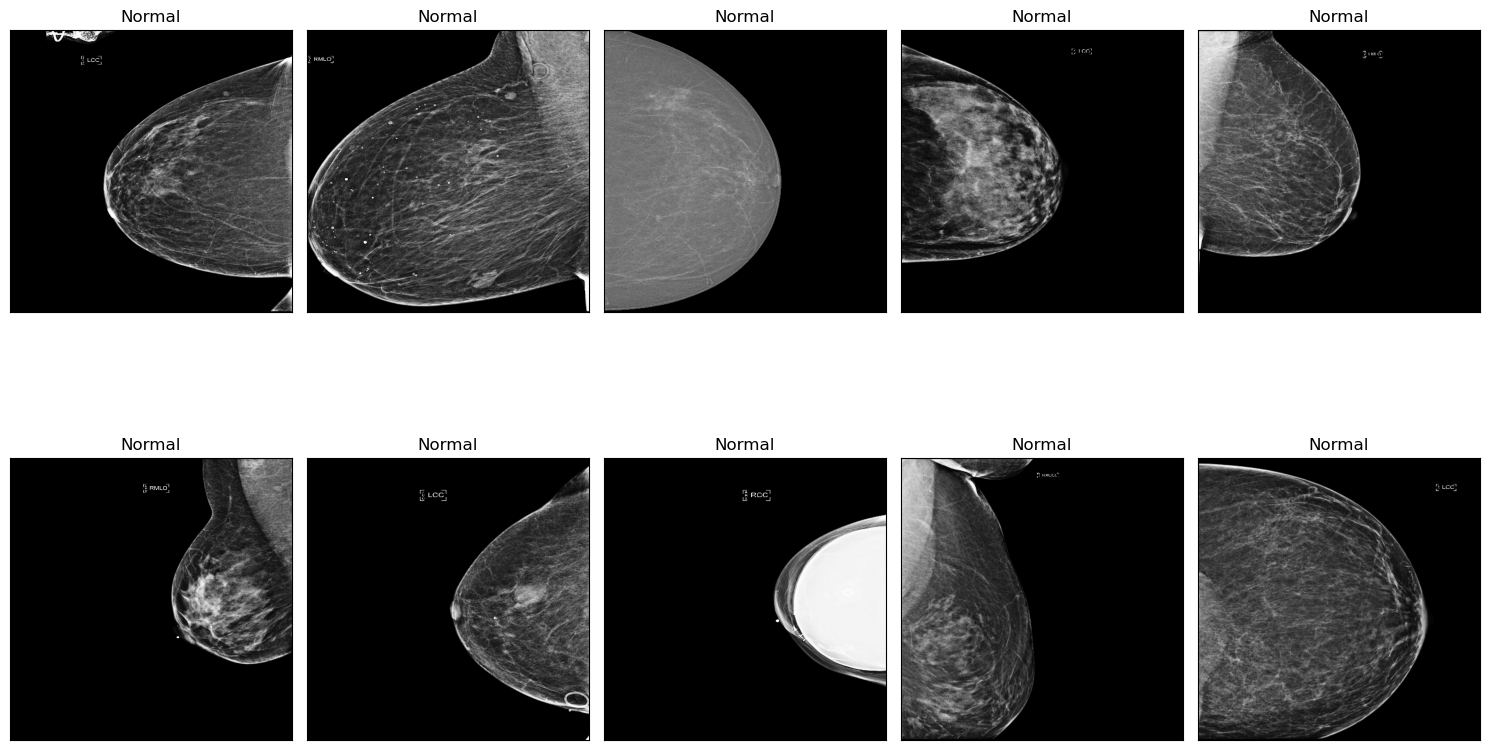

In [183]:
# Affichage des images normales de l'ensemble de données d'entraînement.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

# Parcours des axes pour afficher les images
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])  # Lecture de l'image à partir du chemin
    ax.imshow(img)  # Affichage de l'image
    ax.set_title('Normal')  # Définition du titre de l'axe

fig.tight_layout()
plt.show()


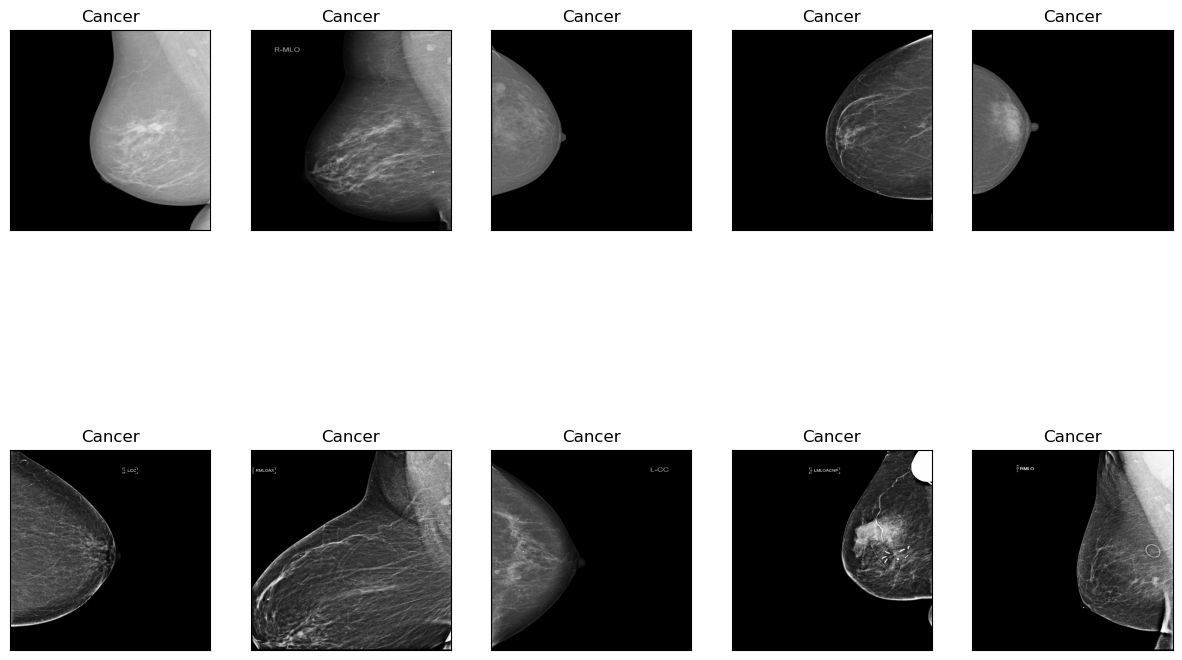

In [184]:
# Affichage des images de cancer de l'ensemble de données d'entraînement.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

# Parcours des axes pour afficher les images
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])  # Lecture de l'image à partir du chemin
    ax.imshow(img)  # Affichage de l'image
    ax.set_title('Cancer')  # Définition du titre de l'axe

plt.show()


#  Création des générateurs de données d'images


In [185]:

# Générateur de données pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255.,  #L'argument rescale=1./255. spécifie que les valeurs des pixels des images seront divisées par 255 pour les ramener dans la plage [0, 1]. Cela permet de normaliser les valeurs des pixels.
    zoom_range=0.2    #L'argument zoom_range=0.2 spécifie la plage de zoom qui peut être appliquée aux images pendant la génération de données d'entraînement. Ici, nous spécifions une plage de zoom de 20%, ce qui signifie que les images peuvent être zoomées jusqu'à 20% à la fois.
)

# Générateur de données pour l'ensemble de validation
val_datagen = ImageDataGenerator(
    rescale=1./255.
)
#Ces générateurs de données seront utilisés ultérieurement pour prétraiter les images lors de l'entraînement et de la validation du modèle.

# **Définir le modèle**

In [193]:
# Définition du modèle (Transfer Learning)
# Utilisation de ResNet50V2 comme modèle de base pour le transfert d'apprentissage
#Nous commençons par charger le modèle ResNet50V2 pré-entraîné en spécifiant weights='imagenet'. 
#L'argument input_shape=(512, 512, 3) définit la taille d'entrée attendue des images.
# L'argument include_top=False indique que
# nous excluons la couche de classification finale du modèle pré-entraîné.
base_model = ResNet50V2(weights='imagenet', input_shape=(512, 512, 3), include_top=False)

# Geler les poids du modèle de base
for layer in base_model.layers:
    layer.trainable = False #  nous gelons les poids du modèle de base en itérant sur ses couches et en définissant layer.trainable = False pour chaque couche.

# Construction du modèle complet
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())# pour réduire les dimensions spatiales
model.add(Dense(128, activation='relu'))#de 128 neurones avec une fonction d'activation ReLU.
model.add(Dropout(0.2)) # pour la régularisation
model.add(Dense(1, activation='sigmoid')) # avec une seule sortie et une activation sigmoïde.

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#optimizer="adam" comme optimiseur,
# loss='binary_crossentropy' comme fonction de perte pour un problème de classification binaire,
# et metrics=["accuracy"] pour évaluer la précision du modèle pendant l'entraînement.


In [194]:
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 128)               262272    
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
___________________________________

#Train the Model¶
 Le modèle a été entraîné avec les données d'entraînement et de validation. Un arrêt précoce (early stopping) a été ajouté pour prévenir le surapprentissage. En réalité, il serait préférable de définir un plus grand nombre d'époques si nécessaire.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)
#monitor="val_loss" : surveille la perte de validation pour déterminer si l'entraînement doit être arrêté.
#mode="min" : cherche à minimiser la valeur surveillée (dans ce cas, la perte de validation).
#patience=4 : spécifie le nombre d'époques sans amélioration de la perte de validation avant d'arrêter l'entraînement.

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 15, epochs = 25, callbacks = callback)

#Le modèle est entraîné en utilisant la méthode fit avec les paramètres suivants :

#train_generator : le générateur de données d'entraînement.
#validation_data=validation_generator : le générateur de données de validation.
#steps_per_epoch=20 : le nombre d'étapes (lots) par époque.
#epochs=15 : le nombre total d'époques d'entraînement.
#callbacks=callback : le rappel d'arrêt précoce pour surveiller la Loss de validation.

Epoch 1/25
15/15 [==============================] - 49s 3s/step - loss: 0.6824 - accuracy: 0.6062 - val_loss: 0.6237 - val_accuracy: 0.6396
Epoch 2/25
15/15 [==============================] - 44s 3s/step - loss: 0.6571 - accuracy: 0.6229 - val_loss: 0.6682 - val_accuracy: 0.6359
Epoch 3/25
15/15 [==============================] - 44s 3s/step - loss: 0.6462 - accuracy: 0.6396 - val_loss: 0.7873 - val_accuracy: 0.5878
Epoch 4/25
15/15 [==============================] - 44s 3s/step - loss: 0.6539 - accuracy: 0.6208 - val_loss: 0.6024 - val_accuracy: 0.6821
Epoch 5/25
15/15 [==============================] - 44s 3s/step - loss: 0.6199 - accuracy: 0.6542 - val_loss: 0.6010 - val_accuracy: 0.6876
Epoch 6/25
15/15 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.6458

# Save the Model


In [ ]:
model.save('mammography_pred_model.h5')

# Model Metrics¶


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualisation de la précision et de la perte.

In [ ]:
plt.figure(figsize=(15, 10)) # Crée une figure avec une taille spécifiée.

plt.subplot(2, 2, 1) # Crée un sous-graphique avec une disposition en 2x2 et sélectionne le premier sous-graphique.
plt.plot(accuracy, label = "Training Accuracy")# Trace la courbe de précision d'entraînement.
plt.plot(val_accuracy, label = "Validation Accuracy") # Trace la courbe de précision de validation.
plt.ylim(0.4, 1) # Définit la limite verticale de l'axe y.
plt.legend(['Train', 'Validation'], loc = 'upper left')# Ajoute une légende au graphique.
plt.title("Training vs Validation Accuracy") # Définit le titre du graphique.
plt.xlabel('epoch') # Définit le label de l'axe x.
plt.ylabel('accuracy') # Définit le label de l'axe y.

plt.subplot(2, 2, 2) # Crée un sous-graphique avec une disposition en 2x2 et sélectionne le deuxième sous-graphique.
plt.plot(loss, label = "Training Loss") # Trace la courbe de perte d'entraînement.
plt.plot(val_loss, label = "Validation Loss") # Trace la courbe de perte de validation.
plt.legend(['Train', 'Validation'], loc = 'upper left') # Ajoute une légende au graphique.
plt.title("Training vs Validation Loss") # Définit le titre du graphique.
plt.xlabel('epoch') # Définit le label de l'axe x.
plt.ylabel('loss') # Définit le label de l'axe y.

plt.show() # Affiche le graphique.

# Prédictions
Afin d'évaluer la qualité du modèle entraîné, les résultats ont été prédits à partir des données de test (validation) et comparés aux valeurs observées. Le seuil a été fixé à 0.5 et les valeurs prédites supérieures à 0.5 ont été considérées comme positives (1).



In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [ ]:
#Prédiction des résultats en utilisant le modèle sur le générateur de validation.
pred = model.predict(validation_generator)

In [ ]:
# prediction by the AI
pred

In [ ]:
#Création d'une liste de prédictions (y_pred) à partir des probabilités prédites.
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
print(y_pred)

In [ ]:
#Crée une série à partir de la liste y_pred et compte les occurrences de chaque valeur.
pd.Series(y_pred).value_counts()


In [ ]:
#Obtient les vraies étiquettes des données de validation en utilisant la propriété 'classes' du générateur de données de validation.
y_true = validation_generator.classes


In [ ]:
print(y_true)


# Confusion Matrix¶


In [ ]:

cm = confusion_matrix(y_true, y_pred) #calcule la matrice de confusion en comparant les valeurs prédites (y_pred) avec les valeurs réelles (y_true).


In [ ]:
# Define the class names.
class_names = ['Normal', 'Cancer'] #définit les noms de classe, qui seront utilisés comme étiquettes des axes sur la matrice de confusion.

# Create the heatmap with class names as tick labels.
# crée un heatmap (carte de chaleur) à partir de la matrice de confusion. Les valeurs de la matrice de confusion sont affichées dans chaque cellule du heatmap, avec une couleur correspondant au niveau d'erreur.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names) 

# Set the axis labels. 
#définissent les étiquettes des axes x et y sur le heatmap, indiquant "Prediction" pour l'axe x (prédictions) et "Truth" pour l'axe y (vérité).
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

# rapport de classification
Le rapport de classification décrit la précision, le rappel et le score F1 pour chaque valeur. Beaucoup de personnes considèrent la précision et le score F1 comme les indicateurs les plus importants pour évaluer un modèle d'IA. Cela peut être correct, mais ce n'est pas nécessairement le cas dans le domaine clinique. Il est important de réfléchir à la manière dont l'IA peut être utile et acceptée par les professionnels de la santé. Ils espèrent que l'IA pourra réduire leur charge de travail. Que signifie réduire leur charge de travail grâce à l'IA ? Une idée est d'exclure de nombreux cas négatifs grâce à l'IA, de sorte que les professionnels de la santé n'auraient pas à les examiner et pourraient se concentrer sur les cas positifs restants à traiter. Ainsi, il est nécessaire que l'IA puisse exclure les cas négatifs sans générer de faux négatifs, c'est-à-dire des cas réellement positifs prédits comme négatifs. Sinon, ils devraient re-vérifier les cas négatifs afin de ne pas manquer les cas réellement positifs. Ils doivent absolument éviter la négligence clinique ! Par conséquent, si le modèle d'IA ne produit pas de faux négatifs, le modèle sera considérablement acceptable dans le domaine de la santé, indépendamment de la précision ou du score F1.

In [ ]:
#generates a classification report based on the predicted and true labels. It provides several evaluation metrics such as precision, recall, F1-score, and support for each class. These metrics are useful for assessing the performance of the classification model.
print(classification_report(y_true, y_pred))


#Analyser les résultats

Il est crucial dans le domaine médical d'analyser quels types de cas ont été mal classés par le modèle d'IA, car les erreurs de diagnostic médical doivent être évitées autant que possible. Il est donc nécessaire d'identifier les cas de faux positifs et de faux négatifs. La création d'un tableau de données et d'une matrice de confusion peut visualiser les résultats. Comme discuté précédemment, les cas de faux négatifs doivent être particulièrement évités.

In [ ]:
confusion = []

for i, j in zip(y_true, y_pred):
    if i == 0 and j == 0:
        confusion.append('TN')  # True Negative
    elif i == 1 and j == 1:
        confusion.append('TP')  # True Positive
    elif i == 0 and j == 1:
        confusion.append('FP')  # False Positive
    else:
        confusion.append('FN')  # False Negative


In [ ]:
print(confusion)
#la liste confusion, qui représente le type de prédictions pour chaque paire d'étiquettes réelles et prédites.




In [ ]:
# Création d'un DataFrame à partir de la liste confusion avec une colonne "Results"
confusion_table = pd.DataFrame(data=confusion, columns=["Results"])
confusion_table


In [ ]:
# Création d'un DataFrame avec les prédictions, les valeurs réelles et les résultats de la confusion
confusion_table = pd.DataFrame({'Predicton': y_pred, 'Truth': y_true, 'Results': confusion})
confusion_table
#confusion_table contenant trois colonnes : 'Predicton', 'Truth' et 'Results'. La colonne 'Predicton' contient les valeurs prédites, la colonne 'Truth' contient les valeurs réelles, et la colonne 'Results' contient les résultats de la confusion. Chaque ligne du DataFrame représente une observation, avec les valeurs prédites, les valeurs réelles et les résultats de la confusion correspondants.

In [ ]:
confusion_table.Results == 'FP'


In [ ]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs


In [ ]:
FPs.index

#FPs.index renvoie les indices des lignes dans la DataFrame FPs. Ces indices représentent les positions des faux positifs dans le DataFrame d'origine (confusion_table). En affichant FPs.index, nous obtenons les indices des lignes correspondant aux faux positifs dans notre modèle.


#Cas de mauvaise classification

Il est important de sélectionner les cas erronés jugés par l'IA et d'analyser pourquoi l'IA a fait de mauvais jugements pour ces images.






In [ ]:
import glob # qui permet de rechercher des fichiers à l'aide de motifs (patterns) dans les noms de fichiers.
val_images = glob.glob('/kaggle/working/val/*/*.png')
# la fonction glob.glob pour rechercher tous les fichiers ayant l'extension .png dans le répertoire /kaggle/working/val/ et ses sous-répertoires. Les chemins de ces fichiers sont stockés dans la liste val_images.

In [ ]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# crée une figure avec une disposition de sous-graphiques en 2 lignes et 5 colonnes. La taille de la figure est définie sur 15x10 pouces, et les options subplot_kw sont utilisées pour supprimer les repères des axes (xticks et yticks) sur tous les sous-graphiques.
for i, ax in zip(FPs.index, axes.flat): #Cette boucle itère sur les indices des images faussement positives (FPs.index) et les axes des sous-graphiques (axes.flat). Pour chaque itération, elle charge l'image correspondante à partir du chemin du fichier (val_images[i]) à l'aide de la fonction cv2.imread, l'affiche sur l'axe du sous-graphique (ax.imshow(img)) et définit le titre du sous-graphique comme "False Positive Case" (ax.set_title("False Positive Case")).
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()  # ajuste automatiquement les positions des sous-graphiques pour éviter les chevauchements.  

plt.show()

# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

**Ajustement fin du modèle (Libération des couches du modèle)**

In [ ]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)
#Cette ligne initialise le modèle de base, ResNet50V2, avec des poids pré-entraînés provenant de la base de données ImageNet. La forme d'entrée est définie sur (512, 512, 3), et les couches supérieures (entièrement connectées) sont exclues en définissant include_top sur False.
for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
#Cette boucle itère sur toutes les couches du modèle de base et défini leur attribut trainable à True. En faisant cela, nous permettons aux poids de ces couches d'être mis à jour pendant l'entraînement.    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
#Ces lignes définissent l'architecture complète du modèle. Le modèle de base est ajouté en tant que première couche du modèle Sequential. Ensuite, une couche GlobalAveragePooling2D est ajoutée pour réduire les dimensions spatiales de la sortie. Cela est suivi d'une couche Dense entièrement connectée avec 128 neurones et une activation ReLU. Une couche Dropout est ajoutée pour la régularisation, et enfin, une couche Dense avec un seul neurone et une activation sigmoïde pour la classification binaire.
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])
#Cette ligne compile le modèle avec l'optimiseur Adam, la fonction de perte de la régression logistique binaire (binary cross-entropy), et la métrique d'évaluation de l'exactitude (accuracy)

In [ ]:
model.summary()


In [ ]:
allback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

In [ ]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

In [ ]:
final_accuracy

**Model Metrics¶**

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Visualizing Accuracy and Loss **

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [ ]:
model.save('mammography_pred_model_finetuning.h5')
